# Regression in Python

***
This is a very quick run-through of some basic statistical concepts, adapted from [Lab 4 in Harvard's CS109](https://github.com/cs109/2015lab4) course. Please feel free to try the original lab if you're feeling ambitious :-) The CS109 git repository also has the solutions if you're stuck.

* Linear Regression Models
* Prediction using linear regression

Linear regression is used to model and predict continuous outcomes with normal random errors. There are nearly an infinite number of different types of regression models and each regression model is typically defined by the distribution of the prediction errors (called "residuals") of the type of data. Logistic regression is used to model binary outcomes whereas Poisson regression is used to predict counts. In this exercise, we'll see some examples of linear regression as well as Train-test splits.

The packages we'll cover are: `statsmodels`, `seaborn`, and `scikit-learn`. While we don't explicitly teach `statsmodels` and `seaborn` in the Springboard workshop, those are great libraries to know.
***

<img width=600 height=300 src="https://imgs.xkcd.com/comics/sustainable.png"/>
***

In [1]:
# special IPython command to prepare the notebook for matplotlib and other libraries
%matplotlib inline 

# import packages for data analysis and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# import regression modules for statistical analysis 
import sklearn
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

# import required package for influence plot later
from statsmodels.graphics.regressionplots import *

# special matplotlib argument for improved plots
# set visualization style in seaborn package
from matplotlib import rcParams
sns.set_style('whitegrid')
sns.set_style('ticks')
#sns.set_context("poster")

***
# Part 1: Introduction to Linear Regression
### Purpose of linear regression
***
<div class="span5 alert alert-info">

<p> Given a dataset containing predictor variables $X$ and outcome/response variable $Y$, linear regression can be used to: </p>
<ul>
  <li> Build a <b>predictive model</b> to predict future values of $\hat{Y}$, using new data $X^*$ where $Y$ is unknown.</li>
  <li> Model the <b>strength of the relationship</b> between each independent variable $X_i$ and $Y$</li>
    <ul>
      <li> Many times, only a subset of independent variables $X_i$ will have a linear relationship with $Y$</li>
      <li> Need to figure out which $X_i$ contributes most information to predict $Y$ </li>
    </ul>
   <li>It is in many cases, the first pass prediction algorithm for continuous outcomes. </li>
</ul>
</div>

### A Brief Mathematical Recap
***

[Linear Regression](http://en.wikipedia.org/wiki/Linear_regression) is a method to model the relationship between a set of independent variables $X$ (also knowns as explanatory variables, features, predictors) and a dependent variable $Y$.  This method assumes the relationship between each predictor $X$ is **linearly** related to the dependent variable $Y$. The most basic linear regression model contains one independent variable $X$, we'll call this the simple model. 

$$ Y = \beta_0 + \beta_1 X + \epsilon$$

where $\epsilon$ is considered as an unobservable random variable that adds noise to the linear relationship. In linear regression, $\epsilon$ is assumed to be normally distributed with a mean of 0. In other words, what this means is that on average, if we know $Y$, a roughly equal number of predictions $\hat{Y}$ will be above $Y$ and others will be below $Y$. That is, on average, the error is zero. The residuals, $\epsilon$ are also assumed to be "i.i.d.": independently and identically distributed. Independence means that the residuals are not correlated -- the residual from one prediction has no effect on the residual from another prediction. Correlated errors are common in time series analysis and spatial analyses.

* $\beta_0$ is the intercept of the linear model and represents the average of $Y$ when all independent variables $X$ are set to 0.

* $\beta_1$ is the slope of the line associated with the regression model and represents the average effect of a one-unit increase in $X$ on $Y$.

* Back to the simple model. The model in linear regression is the *conditional mean* of $Y$ given the values in $X$ is expressed a linear function.  

$$ y = f(x) = E(Y | X = x)$$ 

![conditional mean](images/conditionalmean.png)
*Image from http://www.learner.org/courses/againstallodds/about/glossary.html. Note this image uses $\alpha$ and $\beta$ instead of $\beta_0$ and $\beta_1$.*

* The goal is to estimate the coefficients (e.g. $\beta_0$ and $\beta_1$). We represent the estimates of the coefficients with a "hat" on top of the letter.  

$$ \hat{\beta}_0, \hat{\beta}_1 $$

* Once we estimate the coefficients $\hat{\beta}_0$ and $\hat{\beta}_1$, we can use these to predict new values of $Y$ given new data $X$.

$$\hat{y} = \hat{\beta}_0 + \hat{\beta}_1 x_1$$

* Multiple linear regression is when you have more than one independent variable and the estimation involves matrices
    * $X_1$, $X_2$, $X_3$, $\ldots$


* How do you estimate the coefficients? 
    * There are many ways to fit a linear regression model
    * The method called **least squares** is the most common methods
    * We will discuss least squares

$$ Y = \beta_0 + \beta_1 X_1 + \ldots + \beta_p X_p + \epsilon$$ 
    
### Estimating $\hat\beta$: Least squares
***
[Least squares](http://en.wikipedia.org/wiki/Least_squares) is a method that can estimate the coefficients of a linear model by minimizing the squared residuals: 

$$ \mathscr{L} = \sum_{i=1}^N \epsilon_i^2 = \sum_{i=1}^N \left( y_i - \hat{y}_i \right)^2  = \sum_{i=1}^N \left(y_i - \left(\beta_0 + \beta_1 x_i\right)\right)^2 $$

where $N$ is the number of observations and $\epsilon$ represents a residual or error, ACTUAL - PREDICTED.  

#### Estimating the intercept $\hat{\beta_0}$ for the simple linear model

We want to minimize the squared residuals and solve for $\hat{\beta_0}$ so we take the partial derivative of $\mathscr{L}$ with respect to $\hat{\beta_0}$ 

$
\begin{align}
\frac{\partial \mathscr{L}}{\partial \hat{\beta_0}} &= \frac{\partial}{\partial \hat{\beta_0}} \sum_{i=1}^N \epsilon^2 \\
&= \frac{\partial}{\partial \hat{\beta_0}} \sum_{i=1}^N \left( y_i - \hat{y}_i \right)^2 \\
&= \frac{\partial}{\partial \hat{\beta_0}} \sum_{i=1}^N \left( y_i - \left( \hat{\beta}_0 + \hat{\beta}_1 x_i \right) \right)^2 \\
&= -2 \sum_{i=1}^N \left( y_i - \left( \hat{\beta}_0 + \hat{\beta}_1 x_i \right) \right) \hspace{25mm} \mbox{(by chain rule)} \\
&= -2 \sum_{i=1}^N (y_i - \hat{\beta}_0 - \hat{\beta}_1 x_i) \\
&= -2 \left[ \left( \sum_{i=1}^N y_i \right) - N \hat{\beta_0} - \hat{\beta}_1 \left( \sum_{i=1}^N x_i
\right) \right] \\
& 2 \left[ N \hat{\beta}_0 + \hat{\beta}_1 \sum_{i=1}^N x_i - \sum_{i=1}^N y_i \right] = 0 \hspace{20mm} \mbox{(Set equal to 0 and solve for $\hat{\beta}_0$)} \\
& N \hat{\beta}_0 + \hat{\beta}_1 \sum_{i=1}^N x_i - \sum_{i=1}^N y_i = 0 \\
& N \hat{\beta}_0 = \sum_{i=1}^N y_i - \hat{\beta}_1 \sum_{i=1}^N x_i \\
& \hat{\beta}_0 = \frac{\sum_{i=1}^N y_i - \hat{\beta}_1 \sum_{i=1}^N x_i}{N} \\
& \hat{\beta}_0 = \frac{\sum_{i=1}^N y_i}{N} - \hat{\beta}_1 \frac{\sum_{i=1}^N x_i}{N} \\
& \boxed{\hat{\beta}_0 = \bar{y} - \hat{\beta}_1 \bar{x}}
\end{align}
$

Using this new information, we can compute the estimate for $\hat{\beta}_1$ by taking the partial derivative of $\mathscr{L}$ with respect to $\hat{\beta}_1$.

$
\begin{align}
\frac{\partial \mathscr{L}}{\partial \hat{\beta_1}} &= \frac{\partial}{\partial \hat{\beta_1}} \sum_{i=1}^N \epsilon^2 \\
&= \frac{\partial}{\partial \hat{\beta_1}} \sum_{i=1}^N \left( y_i - \hat{y}_i \right)^2 \\
&= \frac{\partial}{\partial \hat{\beta_1}} \sum_{i=1}^N \left( y_i - \left( \hat{\beta}_0 + \hat{\beta}_1 x_i \right) \right)^2 \\
&= 2 \sum_{i=1}^N \left( y_i - \left( \hat{\beta}_0 + \hat{\beta}_1 x_i \right) \right) \left( -x_i \right) \hspace{25mm}\mbox{(by chain rule)} \\
&= -2 \sum_{i=1}^N x_i \left( y_i - \hat{\beta}_0 - \hat{\beta}_1 x_i \right) \\
&= -2 \sum_{i=1}^N x_i (y_i - \hat{\beta}_0 x_i - \hat{\beta}_1 x_i^2) \\
&= -2 \sum_{i=1}^N x_i (y_i - \left( \bar{y} - \hat{\beta}_1 \bar{x} \right) x_i - \hat{\beta}_1 x_i^2) \\
&= -2 \sum_{i=1}^N (x_i y_i - \bar{y}x_i + \hat{\beta}_1\bar{x}x_i - \hat{\beta}_1 x_i^2) \\
&= -2 \left[ \sum_{i=1}^N x_i y_i - \bar{y} \sum_{i=1}^N x_i + \hat{\beta}_1\bar{x}\sum_{i=1}^N x_i - \hat{\beta}_1 \sum_{i=1}^N x_i^2 \right] \\
&= -2 \left[ \hat{\beta}_1 \left\{ \bar{x} \sum_{i=1}^N x_i - \sum_{i=1}^N x_i^2 \right\} + \left\{ \sum_{i=1}^N x_i y_i - \bar{y} \sum_{i=1}^N x_i \right\}\right] \\
& 2 \left[ \hat{\beta}_1 \left\{ \sum_{i=1}^N x_i^2 - \bar{x} \sum_{i=1}^N x_i \right\} + \left\{ \bar{y} \sum_{i=1}^N x_i - \sum_{i=1}^N x_i y_i \right\} \right] = 0 \\
& \hat{\beta}_1 = \frac{-\left( \bar{y} \sum_{i=1}^N x_i - \sum_{i=1}^N x_i y_i \right)}{\sum_{i=1}^N x_i^2 - \bar{x}\sum_{i=1}^N x_i} \\
&= \frac{\sum_{i=1}^N x_i y_i - \bar{y} \sum_{i=1}^N x_i}{\sum_{i=1}^N x_i^2 - \bar{x} \sum_{i=1}^N x_i} \\
& \boxed{\hat{\beta}_1 = \frac{\sum_{i=1}^N x_i y_i - \bar{x}\bar{y}n}{\sum_{i=1}^N x_i^2 - n \bar{x}^2}}
\end{align}
$

The solution can be written in compact matrix notation as

$$\hat\beta =  (X^T X)^{-1}X^T Y$$ 

We wanted to show you this in case you remember linear algebra, in order for this solution to exist we need $X^T X$ to be invertible. Of course this requires a few extra assumptions, $X$ must be full rank so that $X^T X$ is invertible, etc. Basically, $X^T X$ is full rank if all rows and columns are linearly independent. This has a loose relationship to variables and observations being independent respective. **This is important for us because this means that having redundant features in our regression models will lead to poorly fitting (and unstable) models.** We'll see an implementation of this in the extra linear regression example.

***
# Part 2: Exploratory Data Analysis for Linear Relationships

The [Boston Housing data set](https://archive.ics.uci.edu/ml/datasets/Housing) contains information about the housing values in suburbs of Boston.  This dataset was originally taken from the StatLib library which is maintained at Carnegie Mellon University and is now available on the UCI Machine Learning Repository. 


## Load the Boston Housing data set from `sklearn`
***

This data set is available in the [sklearn](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_boston.html#sklearn.datasets.load_boston) python module which is how we will access it today.  

In [2]:
from sklearn.datasets import load_boston
import pandas as pd

boston = load_boston()

In [3]:
boston.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'filename'])

In [4]:
boston.data.shape

(506, 13)

In [5]:
# Print column names
print(boston.feature_names)

['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT']


In [6]:
# print description of Boston housing data set
print(boston.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

Now let's explore the data set itself. 

In [10]:
# import boston housing prices data

bos = pd.DataFrame(boston.data)
bos.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


There are no column names in the DataFrame. Let's add those. 

In [11]:
# add column names to the dataframe

bos.columns = boston.feature_names
bos.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


Now we have a pandas DataFrame called `bos` containing all the data we want to use to predict Boston Housing prices.  Let's create a variable called `PRICE` which will contain the prices. This information is contained in the `target` data. 

In [12]:
print(boston.target.shape)

(506,)


In [13]:
# include predictor variable in the dataframe itself

bos['PRICE'] = boston.target
bos.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


## EDA and Summary Statistics
***

Let's explore this data set.  First we use `describe()` to get basic summary statistics for each of the columns. 

In [14]:
bos.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


### Scatterplots
***

Let's look at some scatter plots for three variables: 'CRIM' (per capita crime rate), 'RM' (number of rooms) and 'PTRATIO' (pupil-to-teacher ratio in schools).  

Text(0.5, 1.0, 'Relationship between CRIM and Price')

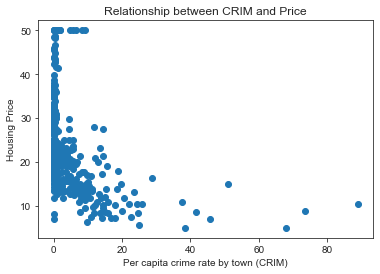

In [15]:
plt.scatter(bos.CRIM, bos.PRICE)
plt.xlabel("Per capita crime rate by town (CRIM)")
plt.ylabel("Housing Price")
plt.title("Relationship between CRIM and Price")

<div class="span5 alert alert-info">
<h3>Part 2 Checkup Exercise Set I</h3>

<p><b>Exercise:</b> What kind of relationship do you see? e.g. positive, negative?  linear? non-linear? Is there anything else strange or interesting about the data? What about outliers?</p>


<p><b>Exercise:</b> Create scatter plots between *RM* and *PRICE*, and *PTRATIO* and *PRICE*. Label your axes appropriately using human readable labels. Tell a story about what you see.</p>

<p><b>Exercise:</b> What are some other numeric variables of interest? Why do you think they are interesting? Plot scatterplots with these variables and *PRICE* (house price) and tell a story about what you see.</p>

</div>

The association between crime rate and housing price is negative - price decreases when the crime rate increases.

The relationship seems exponential (rather than linear) - the slightest existence of the crime rate brings the price of houses down a lot. However, there are cases where even with no crime rate, the prices are much lower compared to others with zero crime rate, implying other factors that must be affecting the pricing of such houses.

Text(0.5, 1.0, 'Relationship between RM and Price')

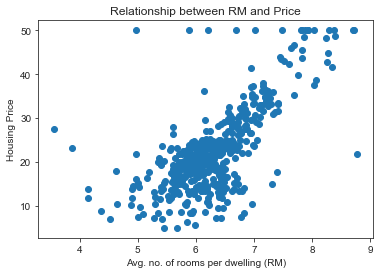

In [16]:
# scatter plot between *RM* and *PRICE*

plt.scatter(bos.RM, bos.PRICE)
plt.xlabel("Avg. no. of rooms per dwelling (RM)")
plt.ylabel("Housing Price")
plt.title("Relationship between RM and Price")

As expected, the association between number of rooms and housing price is linearly positive - price increases with a constant rate on every addition of room per dwelling.

Text(0.5, 1.0, 'Relationship between PTRATIO and Price')

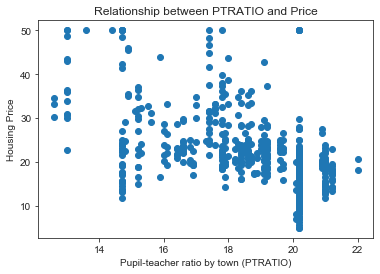

In [17]:
# scatter plot between *PTRATIO* and *PRICE*

plt.scatter(bos.PTRATIO, bos.PRICE)
plt.xlabel("Pupil-teacher ratio by town (PTRATIO)")
plt.ylabel("Housing Price")
plt.title("Relationship between PTRATIO and Price")

As expected, the association between pupil-teacher ratio and housing price is negative - price decreases when the PTRATIO increases. However, the relationship does not seem to be very strong; I expected a stronger relationship between pupil-teacher ratio and housing price. 

Text(0.5, 1.0, 'Relationship between LSTAT and Price')

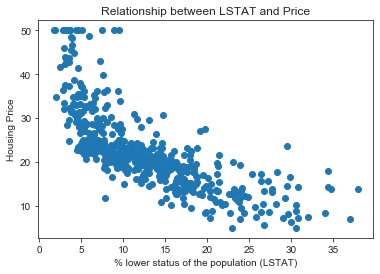

In [18]:
# scatter plot between *LSTAT* and *PRICE*

plt.scatter(bos.LSTAT, bos.PRICE)
plt.xlabel("% lower status of the population (LSTAT)")
plt.ylabel("Housing Price")
plt.title("Relationship between LSTAT and Price")

As expected, higher the percentage of population with lower status in a town, lower is the housing pricing.

Text(0.5, 1.0, 'Relationship between NOX and Price')

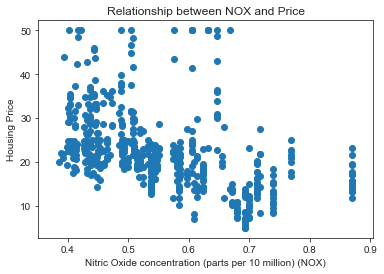

In [19]:
# scatter plot between *NOX* and *PRICE*

plt.scatter(bos.NOX, bos.PRICE)
plt.xlabel("Nitric Oxide concentration (parts per 10 million) (NOX)")
plt.ylabel("Housing Price")
plt.title("Relationship between NOX and Price")

There is negative relationship between NOX and PRICE, albeit weak. As the nitric oxide concentration increases, housing price decreases.

### Scatterplots using Seaborn
***

[Seaborn](https://stanford.edu/~mwaskom/software/seaborn/) is a cool Python plotting library built on top of matplotlib. It provides convenient syntax and shortcuts for many common types of plots, along with better-looking defaults.

We can also use [seaborn regplot](https://stanford.edu/~mwaskom/software/seaborn/tutorial/regression.html#functions-to-draw-linear-regression-models) for the scatterplot above. This provides automatic linear regression fits (useful for data exploration later on). Here's one example below.

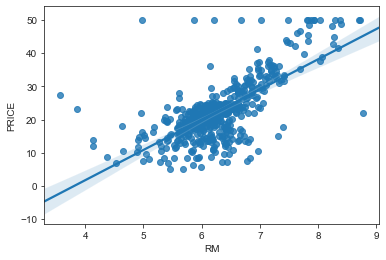

In [20]:
sns.regplot(y="PRICE", x="RM", data=bos, fit_reg = True)

### Histograms
***


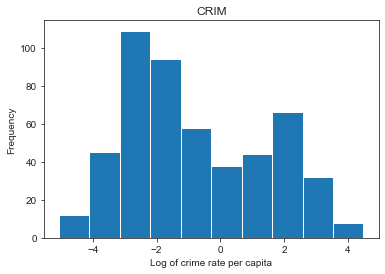

In [21]:
plt.hist(np.log(bos.CRIM))
plt.title("CRIM")
plt.xlabel("Log of crime rate per capita")
plt.ylabel("Frequency")
plt.show()

<div class="span5 alert alert-info">
<h3>Part 2 Checkup Exercise Set II</h3>

<p><b>Exercise:</b> In the above histogram, we took the logarithm of the crime rate per capita. Repeat this histogram without taking the log. What was the purpose of taking the log? What do we gain by making this transformation? What do you now notice about this variable that is not obvious without making the transformation?

<p><b>Exercise:</b> Plot the histogram for *RM* and *PTRATIO* against each other, along with the two variables you picked in the previous section. We are looking for correlations in predictors here.</p>
</div>

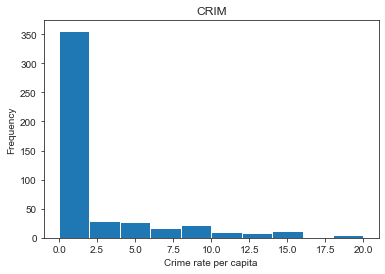

In [22]:
# histogram of crime rate in linear scale

plt.hist(bos.CRIM, bins=10, range=(0,20))
plt.title("CRIM")
plt.xlabel("Crime rate per capita")
plt.ylabel("Frequency")
plt.show()

The linear scale histogram shows skewness towards large crime rates. A logarithmic scale is a nonlinear scale used for a large range of positive multiples of some quantity. Hence, in order to bring down large frequency differences present in linear scale, we use logarithmic scale instead.

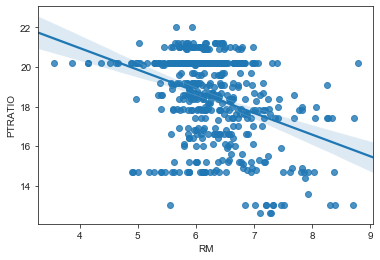

In [23]:
sns.regplot(x="RM", y="PTRATIO", data=bos, fit_reg = True)

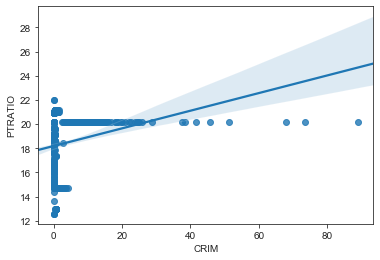

In [24]:
sns.regplot(x="CRIM", y="PTRATIO", data=bos, fit_reg = True)

In [25]:
# correlation matrix for few attributes to check on multi-collinearity

bos[['CRIM','RM','PTRATIO','LSTAT','NOX']].corr()

,CRIM,RM,PTRATIO,LSTAT,NOX
CRIM,1.000000,-0.219247,0.289946,0.455621,0.420972
RM,-0.219247,1.000000,-0.355501,-0.613808,-0.302188
PTRATIO,0.289946,-0.355501,1.000000,0.374044,0.188933
LSTAT,0.455621,-0.613808,0.374044,1.000000,0.590879
NOX,0.420972,-0.302188,0.188933,0.590879,1.000000


There doesn't seem like very strong correlation between any two predictor variables.

## Part 3: Linear Regression with Boston Housing Data Example
***

Here, 

$Y$ = boston housing prices (called "target" data in python, and referred to as the dependent variable or response variable)

and

$X$ = all the other features (or independent variables, predictors or explanatory variables)

which we will use to fit a linear regression model and predict Boston housing prices. We will use the least-squares method to estimate the coefficients.  

We'll use two ways of fitting a linear regression. We recommend the first but the second is also powerful in its features.

### Fitting Linear Regression using `statsmodels`
***
[Statsmodels](http://statsmodels.sourceforge.net/) is a great Python library for a lot of basic and inferential statistics. It also provides basic regression functions using an R-like syntax, so it's commonly used by statisticians. While we don't cover statsmodels officially in the Data Science Intensive workshop, it's a good library to have in your toolbox. Here's a quick example of what you could do with it. The version of least-squares we will use in statsmodels is called *ordinary least-squares (OLS)*. There are many other versions of least-squares such as [partial least squares (PLS)](https://en.wikipedia.org/wiki/Partial_least_squares_regression) and [weighted least squares (WLS)](https://en.wikipedia.org/wiki/Iteratively_reweighted_least_squares).

In [26]:
# statsmodels works nicely with pandas dataframes
# the thing inside the "quotes" is called a formula, a bit on that below

m = ols('PRICE ~ RM',bos).fit()
print(m.summary())

                            OLS Regression Results                            
Dep. Variable:                  PRICE   R-squared:                       0.484
Model:                            OLS   Adj. R-squared:                  0.483
Method:                 Least Squares   F-statistic:                     471.8
Date:                Mon, 09 Dec 2019   Prob (F-statistic):           2.49e-74
Time:                        14:10:00   Log-Likelihood:                -1673.1
No. Observations:                 506   AIC:                             3350.
Df Residuals:                     504   BIC:                             3359.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -34.6706      2.650    -13.084      0.0

#### Interpreting coefficients

There is a ton of information in this output. But we'll concentrate on the coefficient table (middle table). We can interpret the `RM` coefficient (9.1021) by first noticing that the p-value (under `P>|t|`) is so small, basically zero. This means that the number of rooms, `RM`, is a statisticall significant predictor of `PRICE`. The regression coefficient for `RM` of 9.1021 means that *on average, each additional room is associated with an increase of $\$9,100$ in house price net of the other variables*. The confidence interval gives us a range of plausible values for this average change, about ($\$8,279, \$9,925$), definitely not chump change. 

In general, the $\hat{\beta_i}, i > 0$ can be interpreted as the following: "A one unit increase in $x_i$ is associated with, on average, a $\hat{\beta_i}$ increase/decrease in $y$ net of all other variables."

On the other hand, the interpretation for the intercept, $\hat{\beta}_0$ is the average of $y$ given that all of the independent variables $x_i$ are 0.

####  `statsmodels` formulas
***
This formula notation will seem familiar to `R` users, but will take some getting used to for people coming from other languages or are new to statistics.

The formula gives instruction for a general structure for a regression call. For `statsmodels` (`ols` or `logit`) calls you need to have a Pandas dataframe with column names that you will add to your formula. In the below example you need a pandas data frame that includes the columns named (`Outcome`, `X1`,`X2`, ...), but you don't need to build a new dataframe for every regression. Use the same dataframe with all these things in it. The structure is very simple:

`Outcome ~ X1`

But of course we want to to be able to handle more complex models, for example multiple regression is doone like this:

`Outcome ~ X1 + X2 + X3`

In general, a formula for an OLS multiple linear regression is

`Y ~ X1 + X2 + ... + Xp`

This is the very basic structure but it should be enough to get you through the homework. Things can get much more complex. You can force statsmodels to treat variables as categorical with the `C()` function, call numpy functions to transform data such as `np.log` for extremely-skewed data, or fit a model without an intercept by including `- 1` in the formula. For a quick run-down of further uses see the `statsmodels` [help page](http://statsmodels.sourceforge.net/devel/example_formulas.html).


Let's see how our model actually fit our data. We can see below that there is a ceiling effect, we should probably look into that. Also, for large values of $Y$ we get underpredictions, most predictions are below the 45-degree gridlines. 

<div class="span5 alert alert-info">
<h3>Part 3 Checkup Exercise Set I</h3>

<p><b>Exercise:</b> Create a scatterplot between the predicted prices, available in `m.fittedvalues` (where `m` is the fitted model) and the original prices. How does the plot look? Do you notice anything interesting or weird in the plot? Comment on what you see.</p>
</div>

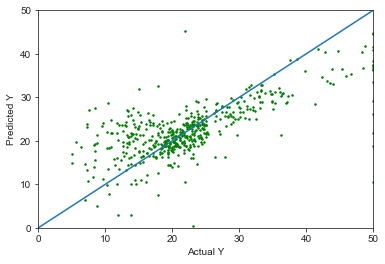

In [27]:
plt.plot(bos['PRICE'], m.fittedvalues, color='green', marker='.', linestyle='none', markersize=3)
plt.ylabel('Predicted Y')
plt.xlabel('Actual Y')
plt.xlim(0,50)
plt.ylim(0,50)
plt.plot([0,50], [0,50])

For lower values of y, the model yields overpredictions. As the actual y increases, model generates underpredictions. 

### Fitting Linear Regression using `sklearn`


In [28]:
from sklearn.linear_model import LinearRegression
X = bos.drop('PRICE', axis=1)

# This creates a LinearRegression object
lm = LinearRegression()
lm

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

#### What can you do with a LinearRegression object? 
***
Check out the scikit-learn [docs here](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html). We have listed the main functions here. Most machine learning models in scikit-learn follow this same API of fitting a model with `fit`, making predictions with `predict` and the appropriate scoring function `score` for each model.

Main functions | Description
--- | --- 
`lm.fit()` | Fit a linear model
`lm.predit()` | Predict Y using the linear model with estimated coefficients
`lm.score()` | Returns the coefficient of determination (R^2). *A measure of how well observed outcomes are replicated by the model, as the proportion of total variation of outcomes explained by the model*

#### What output can you get?

In [ ]:
# Look inside lm object
# lm.<tab>

Output | Description
--- | --- 
`lm.coef_` | Estimated coefficients
`lm.intercept_` | Estimated intercept 

### Fit a linear model
***

The `lm.fit()` function estimates the coefficients the linear regression using least squares. 

In [29]:
# Use all 13 predictors to fit linear regression model

lm.fit(X, bos.PRICE)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

<div class="span5 alert alert-info">
<h3>Part 3 Checkup Exercise Set II</h3>

<p><b>Exercise:</b> How would you change the model to not fit an intercept term? Would you recommend not having an intercept? Why or why not? For more information on why to include or exclude an intercept, look [here](https://stats.idre.ucla.edu/other/mult-pkg/faq/general/faq-what-is-regression-through-the-origin/).</p>

<p><b>Exercise:</b> One of the assumptions of the linear model is that the residuals must be i.i.d. (independently and identically distributed). To satisfy this, is it enough that the residuals are normally distributed? Explain your answer.</p>

<p><b>Exercise:</b> True or false. To use linear regression, $Y$ must be normally distributed. Explain your answer.</p>
</div>


There is only one predictor variable RM (average number of rooms per dwelling) which should make housing price zero if it is zero (implying that the dwellings do not have any room). However, if RM=0 implies that they are studio apartments, then even this premise is no more valid - in that case, PRICE<>0 if RM=0.

For every other variable being zero, housing price is not supposed to be zero; hence, constant term should exist.

In order to not fit intercept term in the model, we need to set the parameter fit_intercept as False while instantiating the linear regression model as follows, before fitting the model to the available data.

lm = LinearRegression(fir_intercept=False)

One of the assumptions of the linear model is that the residuals must be i.i.d. (independently and identically distributed). To satisfy this, is it NOT enough that the residuals are normally distributed. The residuals should be normally distributed around regression line and should not be correlated i.e. the residual from one prediction should not have any effect on the residual from another prediction. Also, the variance of residuals should be constant.

Yes, to use linear regression, Y must be normally distributed around regression line (predicted Y).

### Estimated intercept and coefficients

Let's look at the estimated coefficients from the linear model using `1m.intercept_` and `lm.coef_`.  

After we have fit our linear regression model using the least squares method, we want to see what are the estimates of our coefficients $\beta_0$, $\beta_1$, ..., $\beta_{13}$: 

$$ \hat{\beta}_0, \hat{\beta}_1, \ldots, \hat{\beta}_{13} $$



In [30]:
print('Estimated intercept coefficient: {}'.format(lm.intercept_))

Estimated intercept coefficient: 36.45948838509015


In [31]:
print('Number of coefficients: {}'.format(len(lm.coef_)))

Number of coefficients: 13


In [32]:
# the regression equation coefficients

pd.DataFrame({'features': X.columns, 'estimatedCoefficients': lm.coef_})[['features', 'estimatedCoefficients']]

,features,estimatedCoefficients
0,CRIM,-0.108011
1,ZN,0.046420
2,INDUS,0.020559
3,CHAS,2.686734
4,NOX,-17.766611
5,RM,3.809865
6,AGE,0.000692
7,DIS,-1.475567
8,RAD,0.306049
9,TAX,-0.012335


### Predict Prices 

We can calculate the predicted prices ($\hat{Y}_i$) using `lm.predict`. 

$$ \hat{Y}_i = \hat{\beta}_0 + \hat{\beta}_1 X_1 + \ldots \hat{\beta}_{13} X_{13} $$

In [33]:
# first five predicted prices
lm.predict(X)[0:5]

array([30.00384338, 25.02556238, 30.56759672, 28.60703649, 27.94352423])

<div class="span5 alert alert-info">
<h3>Part 3 Checkup Exercise Set III</h3>

<p><b>Exercise:</b> Histogram: Plot a histogram of all the predicted prices. Write a story about what you see. Describe the shape, center and spread of the distribution. Are there any outliers? What might be the reason for them? Should we do anything special with them?</p>

<p><b>Exercise:</b> Scatterplot: Let's plot the true prices compared to the predicted prices to see they disagree (we did this with `statsmodels` before).</p>

<p><b>Exercise:</b> We have looked at fitting a linear model in both `statsmodels` and `scikit-learn`. What are the advantages and disadvantages of each based on your exploration? Based on the information provided by both packages, what advantage does `statsmodels` provide?</p>
</div>

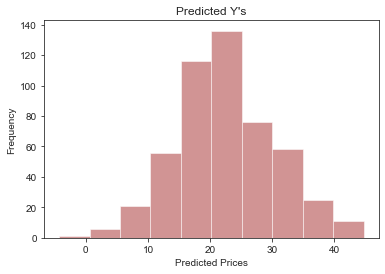

In [34]:
plt.hist(lm.predict(X), color='brown', alpha=0.5)
plt.title("Predicted Y's")
plt.xlabel("Predicted Prices")
plt.ylabel("Frequency")
plt.show()

The distribution looks like a gamma distribution with just one peak in range of 20,000 to 25,000. It doesn't seem like that there is any outlier.

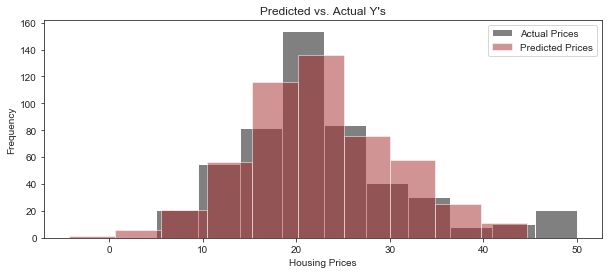

In [35]:
plt.figure(figsize=(10,4))
plt.hist(bos.PRICE, label='Actual Prices', color='gray')
plt.hist(lm.predict(X), label='Predicted Prices', color='brown', alpha=0.5)
plt.title("Predicted vs. Actual Y's")
plt.xlabel("Housing Prices")
plt.ylabel("Frequency")
plt.legend()
plt.show()

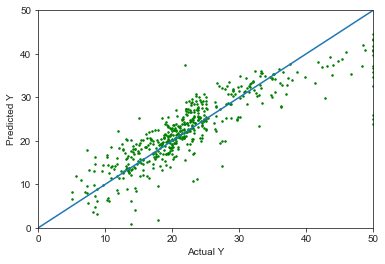

In [36]:
plt.plot(bos['PRICE'], lm.predict(X), color='green', marker='.', linestyle='none', markersize=3)
plt.ylabel('Predicted Y')
plt.xlabel('Actual Y')
plt.xlim(0,50)
plt.ylim(0,50)
plt.plot([0,50], [0,50])

Statsmodel provides a more concise implementation of regression model than scikit-learn. 

The former also gives detailed summary of scores of the fitted model such as AIC, BIC, Adjusted-R square, F-statistic, etc.
However, we need to compute such scores in scikit-learn.

### Evaluating the Model: Sum-of-Squares

The partitioning of the sum-of-squares shows the variance in the predictions explained by the model and the variance that is attributed to error.

$$TSS = ESS + RSS$$

#### Residual Sum-of-Squares (aka $RSS$)

The residual sum-of-squares is one of the basic ways of quantifying how much error exists in the fitted model. We will revisit this in a bit.

$$ RSS = \sum_{i=1}^N r_i^2 = \sum_{i=1}^N \left(y_i - \left(\beta_0 + \beta_1 x_i\right)\right)^2 $$

In [37]:
# sum-of-squares due to errors (residuals)

print(np.sum((bos.PRICE - lm.predict(X)) ** 2))

11078.784577954977


#### Explained Sum-of-Squares (aka $ESS$)

The explained sum-of-squares measures the variance explained by the regression model.

$$ESS = \sum_{i=1}^N \left( \hat{y}_i - \bar{y} \right)^2 = \sum_{i=1}^N \left( \left( \hat{\beta}_0 + \hat{\beta}_1 x_i \right) - \bar{y} \right)^2$$

In [38]:
# sum-of-squares due to regression (explained)

print(np.sum((lm.predict(X) - np.mean(bos.PRICE)) ** 2))

31637.510837065056


### Evaluating the Model: The Coefficient of Determination ($R^2$)

The coefficient of determination, $R^2$, tells us the percentage of the variance in the response variable $Y$ that can be explained by the linear regression model.

$$ R^2 = \frac{ESS}{TSS} $$

The $R^2$ value is one of the most common metrics that people use in describing the quality of a model, but it is important to note that *$R^2$ increases artificially as a side-effect of increasing the number of independent variables.* While $R^2$ is reported in almost all statistical packages, another metric called the *adjusted $R^2$* is also provided as it takes into account the number of variables in the model, and can sometimes even be used for non-linear regression models!

$$R_{adj}^2 = 1 - \left( 1 - R^2 \right) \frac{N - 1}{N - K - 1} = R^2 - \left( 1 - R^2 \right) \frac{K}{N - K - 1} = 1 - \frac{\frac{RSS}{DF_R}}{\frac{TSS}{DF_T}}$$

where $N$ is the number of observations, $K$ is the number of variables, $DF_R = N - K - 1$ is the degrees of freedom associated with the residual error and $DF_T = N - 1$ is the degrees of the freedom of the total error.

### Evaluating the Model: Mean Squared Error and the $F$-Statistic
***
The mean squared errors are just the *averages* of the sum-of-squares errors over their respective degrees of freedom.

$$MSE = \frac{RSS}{N-K-1}$$

$$MSR = \frac{ESS}{K}$$

**Remember:** Notation may vary across resources particularly the use of $R$ and $E$ in $RSS/ESS$ and $MSR/MSE$. In some resources, E = explained and R = residual. In other resources, E = error and R = regression (explained). **This is a very important distinction that requires looking at the formula to determine which naming scheme is being used.**

Given the MSR and MSE, we can now determine whether or not the entire model we just fit is even statistically significant. We use an $F$-test for this. The null hypothesis is that all of the $\beta$ coefficients are zero, that is, none of them have any effect on $Y$. The alternative is that *at least one* $\beta$ coefficient is nonzero, but it doesn't tell us which one in a multiple regression:

$$H_0: \beta_i = 0, \mbox{for all $i$} \\
H_A: \beta_i > 0, \mbox{for some $i$}$$ 

$$F = \frac{MSR}{MSE} = \left( \frac{R^2}{1 - R^2} \right) \left( \frac{N - K - 1}{K} \right)$$
 
Once we compute the $F$-statistic, we can use the $F$-distribution with $N-K$ and $K-1$ degrees of degrees of freedom to get a p-value.

**Warning!** The $F$-statistic mentioned in this section is NOT the same as the F1-measure or F1-value discused in Unit 7.

<div class="span5 alert alert-info">
<h3>Part 3 Checkup Exercise Set IV</h3>

<p>Let's look at the relationship between `PTRATIO` and housing price.</p>

<p><b>Exercise:</b> Try fitting a linear regression model using only the 'PTRATIO' (pupil-teacher ratio by town) and interpret the intercept and the coefficients.</p>

<p><b>Exercise:</b> Calculate (or extract) the $R^2$ value. What does it tell you?</p>

<p><b>Exercise:</b> Compute the $F$-statistic. What does it tell you?</p>

<p><b>Exercise:</b> Take a close look at the $F$-statistic and the $t$-statistic for the regression coefficient. What relationship do you notice? Note that this relationship only applies in *simple* linear regression models.</p>
</div>

In [39]:
# fit a linear model on PTRATIO only using scikit-learn

lm = LinearRegression(fit_intercept=True)
lm.fit(bos[['PTRATIO']], bos['PRICE'])
print("Coefficient:", lm.coef_, "Intercept:", lm.intercept_)

Coefficient: [-2.1571753] Intercept: 62.34462747483266


If pupil-teacher ratio were zero, housing price would be 62,345.
For every unit increase of pupil-teacher ratio, everything else being same, housing price would decrease by 2,157.

In [40]:
# calculate R-square

from sklearn.metrics import r2_score
r2 = r2_score(bos[['PRICE']], lm.predict(bos[['PTRATIO']]))
r2

0.257847318009223

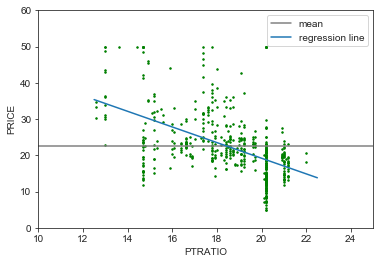

In [41]:
# plot regression line vs. actual data

plt.plot(bos['PTRATIO'], bos['PRICE'], color='green', marker='.', linestyle='none', markersize=3)
plt.xlabel('PTRATIO')
plt.ylabel('PRICE')
plt.axhline(bos['PRICE'].mean(), color='gray', label='mean')
plt.plot([12.5,22.5], [(lm.coef_*12.5)+lm.intercept_, (lm.coef_*22.5)+lm.intercept_], label='regression line')
plt.xlim(10,25)
plt.ylim(0,60)
plt.legend()

R-square value of 0.2578 implies that only 25.78% of total sum of squares can be explained by using the estimated regression equation to predict y.

In [42]:
# calculate F-statistic

f_stat = (r2/(1-r2))*(bos['PRICE'].count()-2)
f_stat

175.10554287569548

F-statistic is 175.1, which is much greater than 1, implying that PTRATIO explains much more than a random vector.

In [43]:
# fit a linear model on PTRATIO only using statsmodel

pt = ols('PRICE ~ PTRATIO',bos).fit()
print(pt.summary())

                            OLS Regression Results                            
Dep. Variable:                  PRICE   R-squared:                       0.258
Model:                            OLS   Adj. R-squared:                  0.256
Method:                 Least Squares   F-statistic:                     175.1
Date:                Mon, 09 Dec 2019   Prob (F-statistic):           1.61e-34
Time:                        14:17:20   Log-Likelihood:                -1764.8
No. Observations:                 506   AIC:                             3534.
Df Residuals:                     504   BIC:                             3542.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     62.3446      3.029     20.581      0.0

F-statistic of the fitted model is 175.1, exact square of t-statistic of PTRATIO's coefficient (-13.233).

<div class="span5 alert alert-info">
<h3>Part 3 Checkup Exercise Set V</h3>

<p>Fit a linear regression model using three independent variables</p>

<ol>
<li> 'CRIM' (per capita crime rate by town)
<li> 'RM' (average number of rooms per dwelling)
<li> 'PTRATIO' (pupil-teacher ratio by town)
</ol>

<p><b>Exercise:</b> Compute or extract the $F$-statistic. What does it tell you about the model?</p>

<p><b>Exercise:</b> Compute or extract the $R^2$ statistic. What does it tell you about the model?</p>

<p><b>Exercise:</b> Which variables in the model are significant in predicting house price? Write a story that interprets the coefficients.</p>
</div>

In [44]:
# R-square and F-statistic for the linear regression model based on CRIM, RM and PTRATIO as predictors of PRICE

lm = LinearRegression()
lm.fit(bos[['CRIM','RM','PTRATIO']], bos[['PRICE']])

r2 = r2_score(bos[['PRICE']], lm.predict(bos[['CRIM','RM','PTRATIO']]))
f_stat = (r2/(1-r2))*((bos['PRICE'].count()-3-1)/(3))

print("R-square:", r2, "\nF-statistic:", f_stat)

R-square: 0.5943412940723471 
F-statistic: 245.16449030064626


In [45]:
# print the model coefficients

lm.coef_

array([[-0.20496083,  7.3804111 , -1.0695461 ]])

In [46]:
# cross-checking the statistics using statsmodel summary

crp = ols('PRICE ~ CRIM + RM + PTRATIO', bos).fit()
print(crp.summary())

                            OLS Regression Results                            
Dep. Variable:                  PRICE   R-squared:                       0.594
Model:                            OLS   Adj. R-squared:                  0.592
Method:                 Least Squares   F-statistic:                     245.2
Date:                Mon, 09 Dec 2019   Prob (F-statistic):           6.15e-98
Time:                        14:18:24   Log-Likelihood:                -1612.0
No. Observations:                 506   AIC:                             3232.
Df Residuals:                     502   BIC:                             3249.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.3707      4.034     -0.836      0.4

F-statistic is 245.2, which is much greater than 1, implying that the model with three predictor attributes explains much more than a random vector.

R-square value of 0.594 implies that only 59.4% of total sum of squares can be explained by using the estimated regression equation to predict y.

p-value of each coefficient is less than 0.05, which means coefficient values are statistically significant (different from zero). Hence, all three attributes in the model are significant in predicting housing price. 

Interpretation of the coefficients:

For every unit increase in crime, everything else being same, housing price decreases by 2050.

For every increase in a room per dwelling, everything else being same, housing price increases by 7380.

For every unit increase in pupil-teacher ratio, everything else being same, housing price decreases by 1069.

## Part 4: Comparing Models

During modeling, there will be times when we want to compare models to see which one is more predictive or fits the data better. There are many ways to compare models, but we will focus on two.

### The $F$-Statistic Revisited

The $F$-statistic can also be used to compare two *nested* models, that is, two models trained on the same dataset where one of the models contains a *subset* of the variables of the other model. The *full* model contains $K$ variables and the *reduced* model contains a subset of these $K$ variables. This allows us to add additional variables to a base model and then test if adding the variables helped the model fit.

$$F = \frac{\left( \frac{RSS_{reduced} - RSS_{full}}{DF_{reduced} - DF_{full}} \right)}{\left( \frac{RSS_{full}}{DF_{full}} \right)}$$

where $DF_x = N - K_x - 1$ where $K_x$ is the number of variables in model $x$.

### Akaike Information Criterion (AIC)

Another statistic for comparing two models is AIC, which is based on the likelihood function and takes into account the number of variables in the model.

$$AIC = 2 K - 2 \log_e{L}$$

where $L$ is the likelihood of the model. AIC is meaningless in the absolute sense, and is only meaningful when compared to AIC values from other models. Lower values of AIC indicate better fitting models.

`statsmodels` provides the AIC in its output.

<div class="span5 alert alert-info">
<h3>Part 4 Checkup Exercises</h3>

<p><b>Exercise:</b> Find another variable (or two) to add to the model we built in Part 3. Compute the $F$-test comparing the two models as well as the AIC. Which model is better?</p>
</div>

In [47]:
# create base and full linear models

blm = LinearRegression()
blm.fit(bos[['CRIM','RM','PTRATIO']], bos[['PRICE']])

flm = LinearRegression()
flm.fit(bos[['CRIM','RM','PTRATIO','LSTAT','NOX']], bos[['PRICE']])

# R-square values for each model

br2 = r2_score(bos[['PRICE']], blm.predict(bos[['CRIM','RM','PTRATIO']]))
fr2 = r2_score(bos[['PRICE']], flm.predict(bos[['CRIM','RM','PTRATIO','LSTAT','NOX']]))

# sum-of-squares total 

sst = ((bos['PRICE']-bos['PRICE'].mean())**2).sum()

# sum-of-squares error

bsse = br2 * sst
fsse = fr2 * sst

# degrees of freedom for each model

bdf = bos['PRICE'].count() - 3 - 1
fdf = bos['PRICE'].count() - 5 - 1

# F-statistic
fstat = ((bsse/fsse)-1)/((bdf/fdf) -1)
fstat

-32.025037839311906

The F-statistic of the full model as compared to the base one is negative, implying that the latter has lower SSE than the former. Hence, the base model is better than the full model.


## Part 5: Evaluating the Model via Model Assumptions and Other Issues
***
Linear regression makes several assumptions. It is always best to check that these assumptions are valid after fitting a linear regression model.

<div class="span5 alert alert-danger">
<ul>
  <li>**Linearity**. The dependent variable $Y$ is a linear combination of the regression coefficients and the independent variables $X$. This can be verified with a scatterplot of each $X$ vs. $Y$ and plotting correlations among $X$. Nonlinearity can sometimes be resolved by [transforming](https://onlinecourses.science.psu.edu/stat501/node/318) one or more independent variables, the dependent variable, or both. In other cases, a [generalized linear model](https://en.wikipedia.org/wiki/Generalized_linear_model) or a [nonlinear model](https://en.wikipedia.org/wiki/Nonlinear_regression) may be warranted.</li>
  <li>**Constant standard deviation**. The SD of the dependent variable $Y$ should be constant for different values of X. We can check this by plotting each $X$ against $Y$ and verifying that there is no "funnel" shape showing data points fanning out as $X$ increases or decreases. Some techniques for dealing with non-constant variance include weighted least squares (WLS), [robust standard errors](https://en.wikipedia.org/wiki/Heteroscedasticity-consistent_standard_errors), or variance stabilizing transformations.
    </li>
  <li> **Normal distribution for errors**.  The $\epsilon$ term we discussed at the beginning are assumed to be normally distributed. This can be verified with a fitted values vs. residuals plot and verifying that there is no pattern, and with a quantile plot.
  $$ \epsilon_i \sim N(0, \sigma^2)$$
Sometimes the distributions of responses $Y$ may not be normally distributed at any given value of $X$.  e.g. skewed positively or negatively. </li>
<li> **Independent errors**.  The observations are assumed to be obtained independently.
    <ul>
        <li>e.g. Observations across time may be correlated
    </ul>
</li>
</ul>  

</div>

There are some other issues that are important to investigate with linear regression models.

<div class="span5 alert alert-danger">
<ul>
  <li>**Correlated Predictors:** Care should be taken to make sure that the independent variables in a regression model are not too highly correlated. Correlated predictors typically do not majorly affect prediction, but do inflate standard errors of coefficients making interpretation unreliable. Common solutions are dropping the least important variables involved in the correlations, using regularlization, or, when many predictors are highly correlated, considering a dimension reduction technique such as principal component analysis (PCA).
  <li>**Influential Points:** Data points that have undue influence on the regression model. These points can be high leverage points or outliers. Such points are typically removed and the regression model rerun.
</ul>
</div>


<div class="span5 alert alert-info">
<h3>Part 5 Checkup Exercises</h3>

<p>Take the reduced model from Part 3 to answer the following exercises. Take a look at the following blog post for more information on using statsmodels to construct these plots.</p>

http://mpastell.com/2013/04/19/python_regression/
    
<p><b>Exercise:</b> Construct a fitted values versus residuals plot. What does the plot tell you? Are there any violations of the model assumptions?</p>

<p><b>Exercise:</b> Construct a quantile plot of the residuals. What does the plot tell you?</p>

<p><b>Exercise:</b> What are some advantages and disadvantages of the fitted vs. residual and quantile plot compared to each other?</p>

<p><b>Exercise:</b> Identify any outliers (if any) in your model and write a story describing what these outliers might represent.</p>

<p><b>Exercise:</b> Construct a leverage plot and identify high leverage points in the model. Write a story explaining possible reasons for the high leverage points.</p>

<p><b>Exercise:</b> Remove the outliers and high leverage points from your model and run the regression again. How do the results change?</p>

Refer to the following article for more information on the subject. 

https://www.jmp.com/en_us/statistics-knowledge-portal/what-is-multiple-regression/mlr-residual-analysis-and-outliers.html
</div>

In [48]:
# fitting a linear model on CRIM, RM and PTRATIO using statsmodel ols package

fitted = ols('PRICE ~ CRIM + RM + PTRATIO', bos).fit()
print(fitted.summary())

res = fitted.resid  # residuals

                            OLS Regression Results                            
Dep. Variable:                  PRICE   R-squared:                       0.594
Model:                            OLS   Adj. R-squared:                  0.592
Method:                 Least Squares   F-statistic:                     245.2
Date:                Mon, 09 Dec 2019   Prob (F-statistic):           6.15e-98
Time:                        14:19:22   Log-Likelihood:                -1612.0
No. Observations:                 506   AIC:                             3232.
Df Residuals:                     502   BIC:                             3249.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.3707      4.034     -0.836      0.4

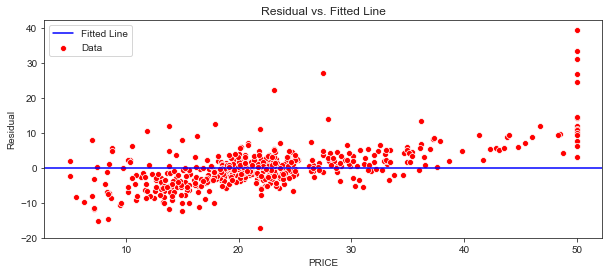

In [49]:
# check for violations of model assumptions

# Fitted vs. Residuals plot

plt.figure(figsize=(10,4))
sns.scatterplot(bos['PRICE'], res, color='r', label='Data')
plt.axhline(0, color='b', label='Fitted Line')
plt.title('Residual vs. Fitted Line')
plt.ylabel('Residual')
plt.legend()

Residuals do not seem to display constant variance. The violation of the constant variance assumption is called “Heteroscedasticity”.

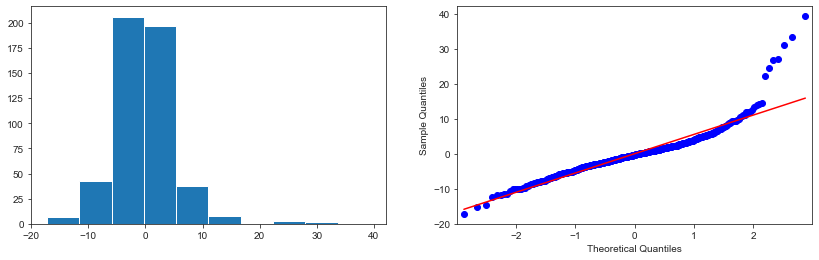

In [50]:
# histogram and QQ plot of the residuals

fig,(ax1,ax2) = plt.subplots(1, 2, figsize=(14,4))
ax1.hist(res, bins=10)
_ = sm.qqplot(res, line='r', ax=ax2)

The histogram does not completely show normal distribution of residuals - there are residuals beyond 20 mark that could be outliers. QQ-plot also confirms the same - there are few data points at the extreme right that wander away the diagonal red line.

Advantages of Fitted vs. Residual plot:

1) Quick and easy way to visualize goodness of fit - how well fitted line goes through actual data

2) Gives a conclusion on whether residuals have constant variance with respect to x values.

Disadvantages:

1) Does not give robust conclusion on whether the residuals are normally distributed.

Advantages of Residual Quantile plot:

1) Quick and robust conclusion on whether residuals are normally distributed and centered around zero.

Disadvantages:

1) Does not show whether residuals have constant variance with respect to x.

2) Does not tell anything about how well the regression line fits actual data distribution.

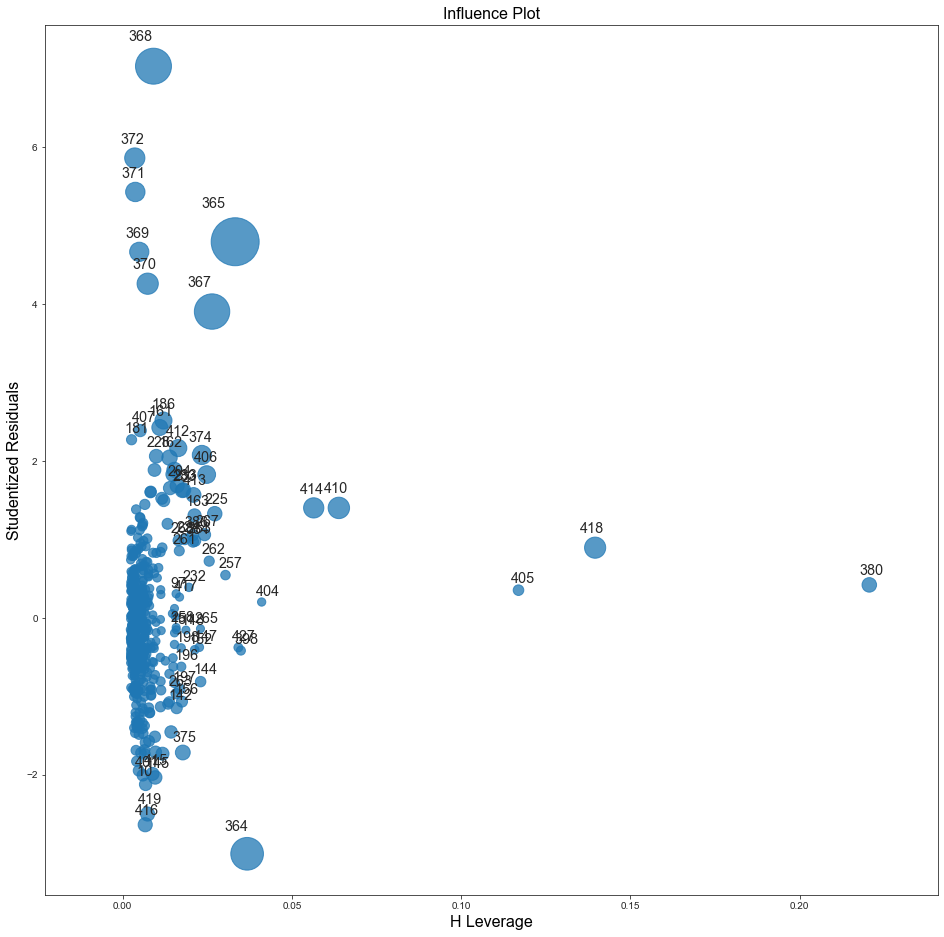

In [51]:
# finding outliers and high leverage points, along with how influential they are

fig,ax = plt.subplots(1, 1, figsize=(16,16))
_ = sm.graphics.influence_plot(fitted, ax=ax, criterion='cooks')

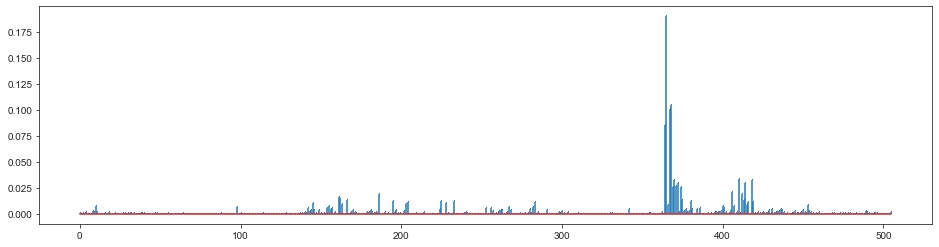

In [52]:
# plot influential measure of the data points

influence = fitted.get_influence()

#c is the distance and p is p-value
(c, p) = influence.cooks_distance

plt.figure(figsize=(16,4))
plt.stem(np.arange(len(c)), c, markerfmt=",", use_line_collection=True)

# create another attribute in the original dataframe to store Cooks Distance for data points
bos['cooksd'] = c

In [53]:
# fetch top five influential data points

bos.nlargest(5, 'cooksd')

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE,cooksd
365,4.55587,0.0,18.1,0.0,0.718,3.561,87.9,1.6132,24.0,666.0,20.2,354.70,7.12,27.5,0.189738
368,4.89822,0.0,18.1,0.0,0.631,4.970,100.0,1.3325,24.0,666.0,20.2,375.52,3.26,50.0,0.104185
367,13.52220,0.0,18.1,0.0,0.631,3.863,100.0,1.5106,24.0,666.0,20.2,131.42,13.33,23.1,0.100813
364,3.47428,0.0,18.1,1.0,0.718,8.780,82.9,1.9047,24.0,666.0,20.2,354.55,5.29,21.9,0.085110
410,51.13580,0.0,18.1,0.0,0.597,5.757,100.0,1.4130,24.0,666.0,20.2,2.60,10.11,15.0,0.033519


While row numbers 365, 368, 367 and 364 are the topmost influential points, the last one (364) is not an outlier - it is still within +3 and -3 of externally normalized residuals range. That said, row numers 369 to 372 are also outliers, but not influential enough. 

Let's first remove the top three influential outliers (365, 368, 367) and see the results. Then, we will check the results after removing the rest four outliers (369 to 372).

In [54]:
# fit a linear model after removing top three influential points only

bosr = bos.drop([365, 368, 367], axis=0)
fittedr = ols('PRICE ~ CRIM + RM + PTRATIO', bosr).fit()
print(fittedr.summary())

                            OLS Regression Results                            
Dep. Variable:                  PRICE   R-squared:                       0.657
Model:                            OLS   Adj. R-squared:                  0.655
Method:                 Least Squares   F-statistic:                     318.3
Date:                Mon, 09 Dec 2019   Prob (F-statistic):          1.91e-115
Time:                        14:23:40   Log-Likelihood:                -1557.2
No. Observations:                 503   AIC:                             3122.
Df Residuals:                     499   BIC:                             3139.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -8.9622      3.745     -2.393      0.0

Removing top three influential outliers increased the R-square from 0.59 to 0.65 and F-statistic from 245 to 318. 

In [55]:
# fit a linear model after removing all seven outliers (including top three influential points)

bosr = bos.drop([365, 368, 367, 369, 370, 371, 372], axis=0)
fittedr = ols('PRICE ~ CRIM + RM + PTRATIO', bosr).fit()
print(fittedr.summary())

                            OLS Regression Results                            
Dep. Variable:                  PRICE   R-squared:                       0.719
Model:                            OLS   Adj. R-squared:                  0.717
Method:                 Least Squares   F-statistic:                     421.5
Date:                Mon, 09 Dec 2019   Prob (F-statistic):          7.11e-136
Time:                        14:24:59   Log-Likelihood:                -1478.3
No. Observations:                 499   AIC:                             2965.
Df Residuals:                     495   BIC:                             2982.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -6.2283      3.291     -1.893      0.0

Removing all seven outliers increased the R-square from 0.59 to 0.72 and F-statistic from 245 to 421.

Removing high leverage points 405, 418 and 380 yields only minimal improvement, since these points are not much influential.